# Language Model

## Import Libraries

In [1]:
import time
import math
import os
from io import open

import torch
import torch.nn as nn
import torch.onnx
import torch.optim as optim
import torch.nn.functional as F

import random
import numpy as np
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
random.seed(1024)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [3]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)

class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r', encoding="utf8") as f:
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r', encoding="utf8") as f:
            idss = []
            for line in f:
                words = line.split() + ['<eos>']
                ids = []
                for word in words:
                    ids.append(self.dictionary.word2idx[word])
                idss.append(torch.tensor(ids).type(torch.int64))
            ids = torch.cat(idss)

        return ids

## Load data

In [4]:
PATH = 'data/'
corpus = Corpus(PATH)

In [5]:
BATCH_SIZE = 256

def batchify(data, bsz):
    nbatch = data.size(0) // bsz
    data = data.narrow(0, 0, nbatch * bsz)
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

eval_batch_size = 10
train_data = batchify(corpus.train, BATCH_SIZE)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

## Model

In [6]:
class FNNModel(nn.Module):
  """
    FNN model
  """

  def __init__(self, d_embedding, d_hidden, window_size, len_vocab, ndrop, tie_weights):
    super(FNNModel, self).__init__()
    self.d_embs = d_embedding
    self.embeddings = nn.Embedding(len_vocab, d_embedding)
    self.W_hid = nn.Linear(d_embedding*window_size, d_hidden)
    self.W_out = nn.Linear(d_hidden, len_vocab)
    self.dropout = nn.Dropout(ndrop)

    if tie_weights:
      if d_embedding != d_hidden:
          raise ValueError('When using the tied flag, nhid must be equal to emsize')
      self.W_out.weight = self.embeddings.weight

    self.init_weights()

  def forward(self, input): 
    window_size, batch_size = input.size()

    embs = self.embeddings(input.T)
    concat_embs = self.dropout(embs.view(batch_size, window_size * self.d_embs))
    hiddens = torch.tanh(self.W_hid(concat_embs))
    outs = self.W_out(hiddens)

    return outs

  def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.embeddings.weight, -initrange, initrange)
        nn.init.zeros_(self.W_out.weight)
        nn.init.uniform_(self.W_out.weight, -initrange, initrange)

In [7]:
def getEightGrams(source, i):
    """
      return an 8-gram context (data) and target
    """
    seq_len = 8 - 1
    start = i - seq_len

    if start < 0:
        return None, None
        
    data = source[i - seq_len:i]
    
    target = source[i].view(-1)
    return data, target

In [8]:
def evaluate(data_source):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
      for i in range(7, data_source.size(0) - 1, 1):
          prefixes, labels = getEightGrams(data_source, i)
          logits = model(prefixes)
          total_loss +=  criterion(logits, labels).item()
    return total_loss / (len(data_source) - 7)

In [9]:
def train(epoch, lr, verbose = True):
    """
      Do backpropagation and parameter update
    """
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    for batch, i in enumerate(range(7, train_data.size(0) - 1, 1)):
        prefixes, labels = getEightGrams(train_data, i)
        logits = model(prefixes)
        loss = criterion(logits, labels)
        model.zero_grad()
        
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        for p in model.parameters():
            p.data.add_(p.grad, alpha=-lr)

        total_loss += loss.item()

        if batch % LOG_INTERVAL == 0 and batch > 0:
            if verbose:
              cur_loss = total_loss / LOG_INTERVAL
              elapsed = time.time() - start_time
              print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | ms/batch {:5.2f} | '
                      'loss {:5.2f} | ppl {:8.2f}'.format(
                  epoch, batch, len(train_data) // 1, lr,
                  elapsed * 1000 / LOG_INTERVAL, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [10]:
criterion = nn.CrossEntropyLoss()
LOG_INTERVAL = 1000

def train_model(num_epochs, model_output_file, lr = 20, verbose=True, eval_train = True):
  """
    train model
  """
  val_losses = []
  train_losses = []
  best_val_loss = None

  try:
      for epoch in range(1, num_epochs+1):
          epoch_start_time = time.time()
          train(epoch, lr, verbose = verbose)

          val_loss = evaluate(val_data)
          val_losses.append(val_loss)
          
          if eval_train:
            train_loss = evaluate(train_data)
            train_losses.append(train_loss)

          if verbose:
            print('-' * 89)
            print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                    'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                              val_loss, math.exp(val_loss)))
            print('-' * 89)
          # Save the model if the validation loss is the best we've seen so far.
          if (not best_val_loss or val_loss < best_val_loss) and model_output_file is not None:
              with open(model_output_file, 'wb') as f:
                  torch.save(model, f)
              best_val_loss = val_loss
          else:
              # Anneal the learning rate if no improvement has been seen in the validation dataset.
              lr /= 4.0
      return train_losses, val_losses

  except KeyboardInterrupt:
      print('-' * 89)
      print('Exiting from training early')

## Helper functions

In [11]:
def plot_loss(train_losses, val_losses, output_file):
  """
    function for plotting train and val losses
  """
  assert len(train_losses) == len(val_losses), "length of train and validation loss should be equal" 
  ep = [i+1 for i in range(len(val_losses))]
  plt.figure(figsize=(15,5))
  plt.plot(ep, train_losses, label = "train loss")
  plt.plot(ep, val_losses, label = "val loss")
  plt.legend( loc='upper right', borderaxespad=0.5)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.savefig(output_file)
  plt.show()

In [12]:
def load_best_model(model_output_file):
  """
    load the best model
  """
  with open(model_output_file, 'rb') as f:
    model = torch.load(f).to(device)
  return model

In [13]:
def eval_test():
  """
    evaluate the model on test data
  """
  test_loss = evaluate(test_data)
  print('=' * 89)
  print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
      test_loss, math.exp(test_loss)))
  print('=' * 89)

In [14]:
def generate_text(output_file):
  """
    generate text using an input sentence as input
  """
  model.eval()
  generate_log_interval = 100
  words = 1000
  temperature = 1.0
  ntokens = len(corpus.dictionary)

  initial_sentence = "He announced he was retiring from professional "
  input = initial_sentence.split()

  data = torch.Tensor([torch.Tensor([corpus.dictionary.word2idx[word]]) for word in input]).long().view(-1,1).to(device)

  with open(output_file, 'w') as outf:
      outf.write(initial_sentence)
      with torch.no_grad(): 
          for i in range(words):
                  
              output = model(data)
              word_weights = output[-1].squeeze().div(temperature).exp().cpu()
              word_idx = torch.multinomial(word_weights, 1)[0]
              word_tensor = torch.Tensor([[word_idx]]).long().to(device)
              data = torch.cat([data[:6], word_tensor])

              word = corpus.dictionary.idx2word[word_idx]
              
              outf.write(word + ('\n' if i % 20 == 19 else ' '))

              if i % generate_log_interval == 0:
                  print('| Generated {}/{} words'.format(i, words))


In [15]:
def eval_generate_text(output_file):
  """
    evaluate the loss and perplexity of generated text
  """
  generated = corpus.tokenize(output_file)
  generate_data = batchify(generated, eval_batch_size)
  gen_loss = evaluate(generate_data)
  print('=' * 89)
  print('| End of training | generate text loss {:5.2f} | generate text ppl {:8.2f}'.format(
      gen_loss, math.exp(gen_loss)))
  print('=' * 89)

In [16]:
def tune_hyperparams(tie_weights, output_file):
  if tie_weights:
    emsizes = [10, 30, 60, 100]
    nhids = [None]
  else:
    emsizes = [10, 50, 100]
    nhids = [10, 50, 100]
  
  num_epochs = 15
  verbose = False

  print('-' * 89)
  print("Hyperparameters tuning using val loss after {:1d} epochs".format(num_epochs))
  print('-' * 89)

  ep = [i+1 for i in range(num_epochs)]
  plt.figure(figsize=(15,5))

  global model

  try:
    for emsize in emsizes:
      for nhid in nhids:

        if nhid is None:
          nhid = emsize

        best_val_loss = None
        torch.manual_seed(1024)
        model = FNNModel(d_embedding=emsize, d_hidden=nhid, window_size=7, len_vocab=len(corpus.dictionary), ndrop=0.5, tie_weights = tie_weights).to(device)

        _, val_losses = train_model(num_epochs = num_epochs, model_output_file=None, verbose=False, eval_train = False)
            
        print("| emsize {:3d} | nhid {:3d} | val loss {:02.4f} | ppl {:8.2f}  ".format(emsize, nhid, min(val_losses), math.exp(min(val_losses))))
        assert len(val_losses) == len(ep), "Length of val loss must be equal to epoch"
        plt.plot(ep, val_losses, label = "| emsize {:3d} | nhid {:3d} |".format(emsize, nhid) )

    plt.legend( loc='upper right', borderaxespad=0.5)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(output_file)
    plt.show()


  except KeyboardInterrupt:
      print('-' * 89)
      print('Exiting from training early')


# Train and test model

-----------------------------------------------------------------------------------------
Hyperparameters tuning using val loss after 15 epochs
-----------------------------------------------------------------------------------------
| emsize  10 | nhid  10 | val loss 6.1859 | ppl   485.87  
| emsize  10 | nhid  50 | val loss 5.9032 | ppl   366.22  
| emsize  10 | nhid 100 | val loss 5.6885 | ppl   295.44  
| emsize  50 | nhid  10 | val loss 6.0635 | ppl   429.86  
| emsize  50 | nhid  50 | val loss 5.7155 | ppl   303.55  
| emsize  50 | nhid 100 | val loss 5.6026 | ppl   271.13  
| emsize 100 | nhid  10 | val loss 6.0309 | ppl   416.10  
| emsize 100 | nhid  50 | val loss 5.6628 | ppl   287.95  
| emsize 100 | nhid 100 | val loss 5.5601 | ppl   259.84  


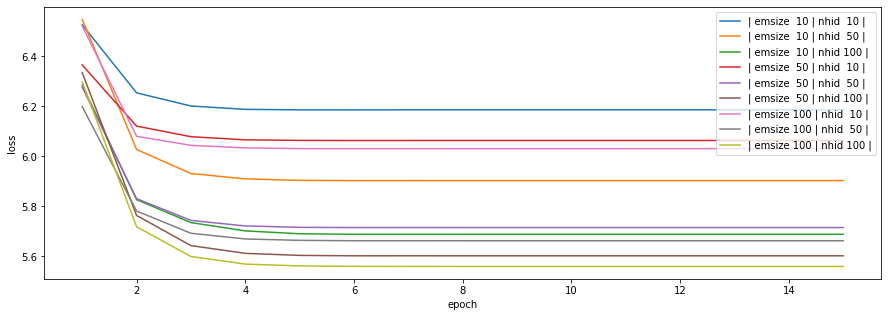

In [17]:
tune_hyperparams(tie_weights = False, output_file = "output/no_tie_weight/tuning_no_tie_weights.png")

| epoch   1 |  1000/ 8158 batches | lr 20.0000 | ms/batch  5.14 | loss  6.97 | ppl  1062.39
| epoch   1 |  2000/ 8158 batches | lr 20.0000 | ms/batch  5.11 | loss  6.58 | ppl   717.80
| epoch   1 |  3000/ 8158 batches | lr 20.0000 | ms/batch  5.14 | loss  6.55 | ppl   702.12
| epoch   1 |  4000/ 8158 batches | lr 20.0000 | ms/batch  5.16 | loss  6.53 | ppl   688.48
| epoch   1 |  5000/ 8158 batches | lr 20.0000 | ms/batch  5.18 | loss  6.51 | ppl   674.97
| epoch   1 |  6000/ 8158 batches | lr 20.0000 | ms/batch  5.18 | loss  6.53 | ppl   685.17
| epoch   1 |  7000/ 8158 batches | lr 20.0000 | ms/batch  5.20 | loss  6.53 | ppl   685.97
| epoch   1 |  8000/ 8158 batches | lr 20.0000 | ms/batch  5.17 | loss  6.53 | ppl   683.44
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 61.85s | valid loss  6.30 | valid ppl   543.29
-----------------------------------------------------------------------------------------
| epoch   

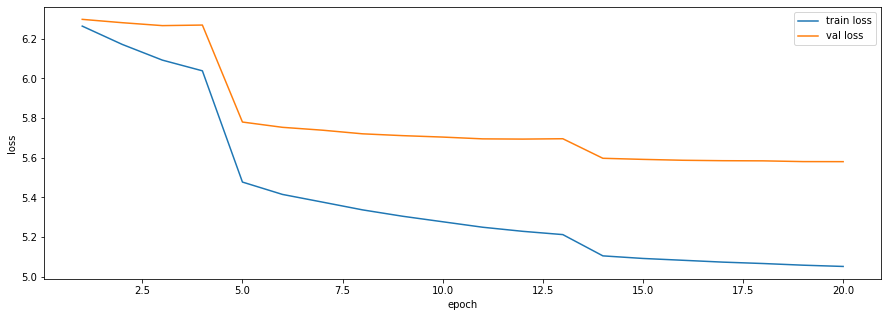

| End of training | test loss  5.50 | test ppl   243.95
| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words
| End of training | generate text loss  6.88 | generate text ppl   968.48


In [18]:
"""
  Train, test and generate text from no tie weight model
"""
num_epochs = 20
model_output_file = 'output/no_tie_weight/model_no_tie_weights.pt'
output_file = 'output/no_tie_weight/generate_text_no_tie_weights.txt'
loss_file = 'output/no_tie_weight/loss_no_tie_weights.png'
torch.manual_seed(1024)
model = FNNModel(d_embedding=100, d_hidden=100, window_size=7, len_vocab=len(corpus.dictionary), ndrop=0.5, tie_weights = False).to(device)
train_losses, val_losses = train_model(num_epochs = num_epochs, model_output_file=model_output_file)
plot_loss(train_losses, val_losses, output_file=loss_file)
model = load_best_model(model_output_file = model_output_file)
eval_test()
generate_text(output_file = output_file)
eval_generate_text(output_file = output_file)

-----------------------------------------------------------------------------------------
Hyperparameters tuning using val loss after 15 epochs
-----------------------------------------------------------------------------------------
| emsize  10 | nhid  10 | val loss 6.2820 | ppl   534.84  
| emsize  30 | nhid  30 | val loss 5.9012 | ppl   365.48  
| emsize  60 | nhid  60 | val loss 5.6131 | ppl   273.98  
| emsize 100 | nhid 100 | val loss 5.4729 | ppl   238.16  


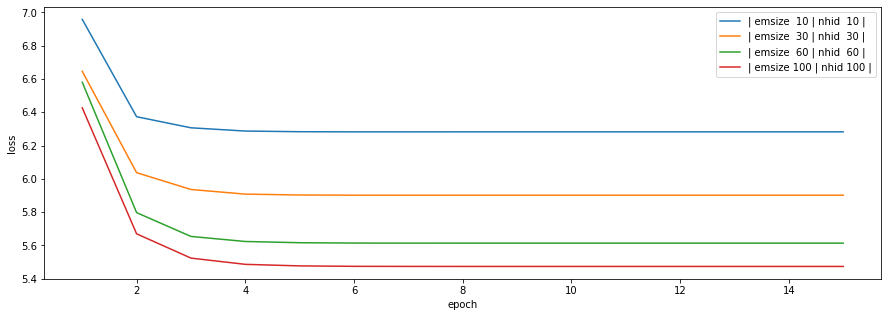

In [19]:
tune_hyperparams(tie_weights = True, output_file = "output/tie_weight/tuning_tie_weights.png")

| epoch   1 |  1000/ 8158 batches | lr 20.0000 | ms/batch 10.92 | loss  7.30 | ppl  1473.33
| epoch   1 |  2000/ 8158 batches | lr 20.0000 | ms/batch 10.96 | loss  6.79 | ppl   892.23
| epoch   1 |  3000/ 8158 batches | lr 20.0000 | ms/batch 10.96 | loss  6.76 | ppl   861.97
| epoch   1 |  4000/ 8158 batches | lr 20.0000 | ms/batch 11.02 | loss  6.74 | ppl   843.13
| epoch   1 |  5000/ 8158 batches | lr 20.0000 | ms/batch 10.95 | loss  6.73 | ppl   833.57
| epoch   1 |  6000/ 8158 batches | lr 20.0000 | ms/batch 10.97 | loss  6.75 | ppl   854.92
| epoch   1 |  7000/ 8158 batches | lr 20.0000 | ms/batch 11.02 | loss  6.76 | ppl   866.59
| epoch   1 |  8000/ 8158 batches | lr 20.0000 | ms/batch 11.02 | loss  6.78 | ppl   884.06
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 135.16s | valid loss  6.43 | valid ppl   618.11
-----------------------------------------------------------------------------------------
| epoch  

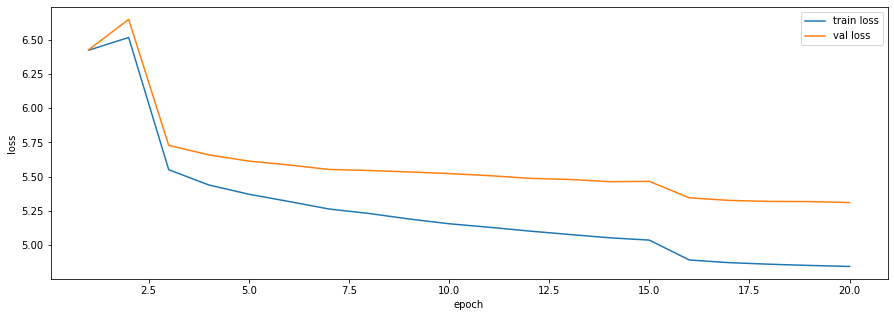

| End of training | test loss  5.24 | test ppl   187.98
| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words
| End of training | generate text loss  6.24 | generate text ppl   513.54


In [20]:
"""
  Train, test and generate text from tie weight model
"""
num_epochs = 20
model_output_file = 'output/tie_weight/model_tie_weights.pt'
output_file = 'output/tie_weight/generate_text_tie weight.txt'
loss_file = 'output/tie_weight/loss_tie_weights.png'
torch.manual_seed(1024)
model = FNNModel(d_embedding=100, d_hidden=100, window_size=7, len_vocab=len(corpus.dictionary), ndrop=0.5, tie_weights = True).to(device)
train_losses, val_losses = train_model(num_epochs = num_epochs, model_output_file=model_output_file)
plot_loss(train_losses, val_losses, output_file=loss_file)
model = load_best_model(model_output_file = model_output_file)
eval_test()
generate_text(output_file = output_file)
eval_generate_text(output_file = output_file)

## Visualize word embeddings

In [21]:
import nltk
import collections
from sklearn.decomposition import PCA
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from numpy import dot
from numpy.linalg import norm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
def get_wemb_cosine_sim():
  queen_idx = corpus.dictionary.word2idx['queen']
  king_idx = corpus.dictionary.word2idx['king']
  man_idx = corpus.dictionary.word2idx['man']
  woman_idx = corpus.dictionary.word2idx['woman']
  computer_idx = corpus.dictionary.word2idx['computer']

  queen_emb = model.embeddings.weight[queen_idx].cpu().detach().numpy()
  king_emb = model.embeddings.weight[king_idx].cpu().detach().numpy()
  man_emb = model.embeddings.weight[man_idx].cpu().detach().numpy()
  woman_emb = model.embeddings.weight[woman_idx].cpu().detach().numpy()
  computer_emb = model.embeddings.weight[computer_idx].cpu().detach().numpy()

  cos_sim = dot(king_emb, queen_emb)/(norm(king_emb)*norm(queen_emb))
  print('Cosine similarity of king and queen:', cos_sim)
  cos_sim = dot(man_emb, woman_emb)/(norm(man_emb)*norm(woman_emb))
  print('Cosine similarity of man and woman:', cos_sim)
  cos_sim = dot(king_emb, man_emb)/(norm(king_emb)*norm(man_emb))
  print('Cosine similarity of king and man:', cos_sim)
  cos_sim = dot(queen_emb, woman_emb)/(norm(queen_emb)*norm(woman_emb))
  print('Cosine similarity of queen and woman:', cos_sim)
  cos_sim = dot(king_emb, computer_emb)/(norm(king_emb)*norm(computer_emb))
  print('Cosine similarity of king and computer:', cos_sim)
  cos_sim = dot(queen_emb, computer_emb)/(norm(queen_emb)*norm(computer_emb))
  print('Cosine similarity of queen and computer:', cos_sim)

In [23]:
word_counter = Counter()
def count_word(path):
   with open(path, 'r', encoding="utf8") as f:
     for line in f:
       words = line.split()
      #  words = [word.lower() for word in words]
       word_counter.update(words)

count_word(os.path.join(PATH, 'train.txt'))
count_word(os.path.join(PATH, 'valid.txt'))
count_word(os.path.join(PATH, 'test.txt'))  

"""
  Get only frequent non-stopword words
"""
frequent_words = [word for word, count in word_counter.items() if count > 1000 and not word in stopwords.words()]

In [24]:
# map word to vector
def get_word_embeddings():
  word_emb = dict()
  for word in frequent_words:
    idx = corpus.dictionary.word2idx[word]
    emb = model.embeddings.weight[idx].cpu().detach().tolist()
    word_emb[word] = emb
  return word_emb

In [25]:
def display_closestwords_tsnescatterplot(word_labels, embs, output_file):
  
    pca = PCA(n_components=2, random_state=0)
    Y = pca.fit_transform(embs)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot 
    plt.figure(figsize=(20,10))
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.savefig(output_file)
    plt.show()
    

Cosine similarity of king and queen: 0.3371352
Cosine similarity of man and woman: 0.53910506
Cosine similarity of king and man: 0.2651133
Cosine similarity of queen and woman: 0.17548701
Cosine similarity of king and computer: 0.06156189
Cosine similarity of queen and computer: 0.059445146


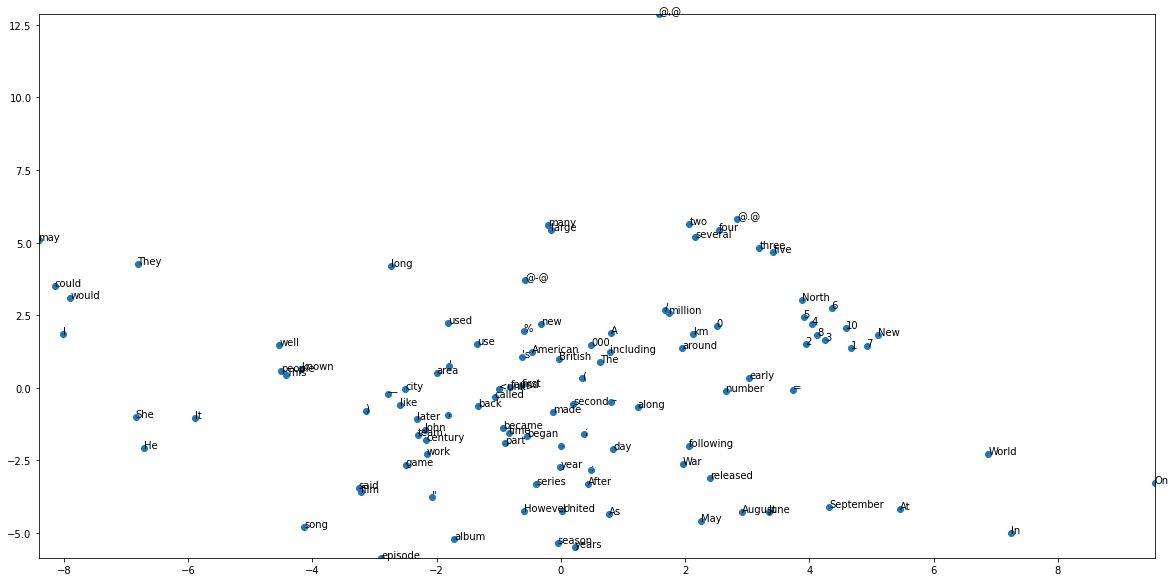

In [26]:
"""
  word embeddings for no tie weights model
"""
model_output_file = 'output/no_tie_weight/model_no_tie_weights.pt'
model = load_best_model(model_output_file)
word_emb = get_word_embeddings()
get_wemb_cosine_sim()
display_closestwords_tsnescatterplot(list(word_emb.keys()), list(word_emb.values()), output_file = 'output/no_tie_weight/word_embedding_no_tie_weights.png')

Cosine similarity of king and queen: 0.66843694
Cosine similarity of man and woman: 0.8269924
Cosine similarity of king and man: 0.54473907
Cosine similarity of queen and woman: 0.4724868
Cosine similarity of king and computer: 0.042319015
Cosine similarity of queen and computer: 0.078673765


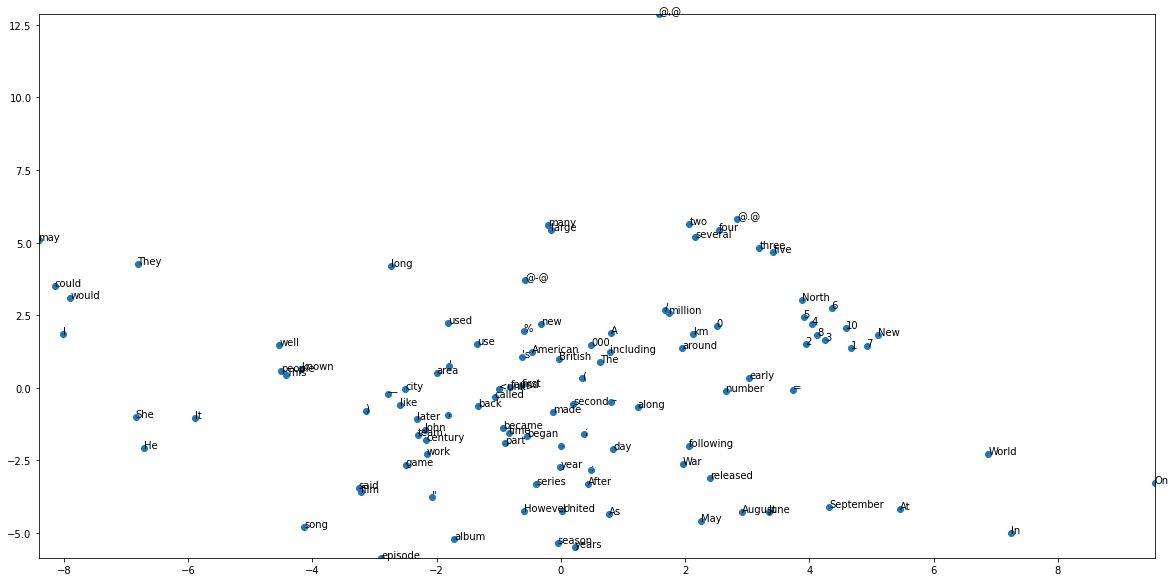

In [27]:
"""
  word embeddings for tie weights model
"""
model_output_file = 'output/tie_weight/model_tie_weights.pt'
model = load_best_model(model_output_file)
word_embs = get_word_embeddings()
get_wemb_cosine_sim()
display_closestwords_tsnescatterplot(list(word_emb.keys()), list(word_emb.values()), output_file = 'output/tie_weight/word_embedding_tie_weights.png')